<a href="https://colab.research.google.com/github/mo-9/Object_Detection/blob/main/tfod_api.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!git clone https://github.com/tensorflow/models.git


fatal: destination path 'models' already exists and is not an empty directory.


In [27]:
from __future__ import division
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from PIL import Image
import cv2
import matplotlib.pyplot as plt


In [4]:
%tensorflow_version 1.x

In [7]:
tf.version

<module 'tensorflow._api.v1.version' from '/tensorflow-1.15.2/python3.7/tensorflow_core/_api/v1/version/__init__.py'>

In [8]:
!pip install tensorflow-object-detection-api


     |████████████████████████████████| 577 kB 2.3 MB/s 
     |████████████████████████████████| 54 kB 2.7 MB/s 
     |████████████████████████████████| 54 kB 2.3 MB/s 
     |████████████████████████████████| 3.5 MB 40.0 MB/s 
  Created wheel for tensorflow-object-detection-api: filename=tensorflow_object_detection_api-0.1.1-py3-none-any.whl size=844512 sha256=ac3e31a7601783dad8f8c712255e6eb8f5f8391edadb829d4e6d48dd89d9e640
  Stored in directory: /root/.cache/pip/wheels/71/7e/a2/461ab817fbaef68ec9cc60df16d3669d1285f032e4c98179bf
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=565564b0553b9c30bc5568e4b67c8ed5f066a2c64f0319c0103967e776ca694c
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built tensorflow-object-detection-api gast
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
ERROR: pip's 

In [9]:



from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")

# Path to frozen detection graph. This is the actual model that is used for the object detection.
# Note: Model used for SSDLite_Mobilenet_v2
PATH_TO_CKPT = '/content/model/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = '/content/data/mscoco_label_map.pbtxt'

NUM_CLASSES = 90

In [14]:
MODEL_NAME = 'ssd_mobilenet_v1_coco_11_06_2017'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('/content/models/research/object_detection/data', 'mscoco_label_map.pbtxt')

NUM_CLASSES = 90

In [15]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
    file_name = os.path.basename(file.name)
    if 'frozen_inference_graph.pb' in file_name:
        tar_file.extract(file, os.getcwd())

In [16]:

detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.compat.v1.GraphDef()
    with tf.compat.v1.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

In [17]:

label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [49]:
%tensorflow_version 1.x

TensorFlow is already loaded. Please restart the runtime to change versions.


In [18]:

def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [24]:
PATH_TO_TEST_IMAGES_DIR = '/content/7.jpg'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, format(i)) for i in range(1, 3) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

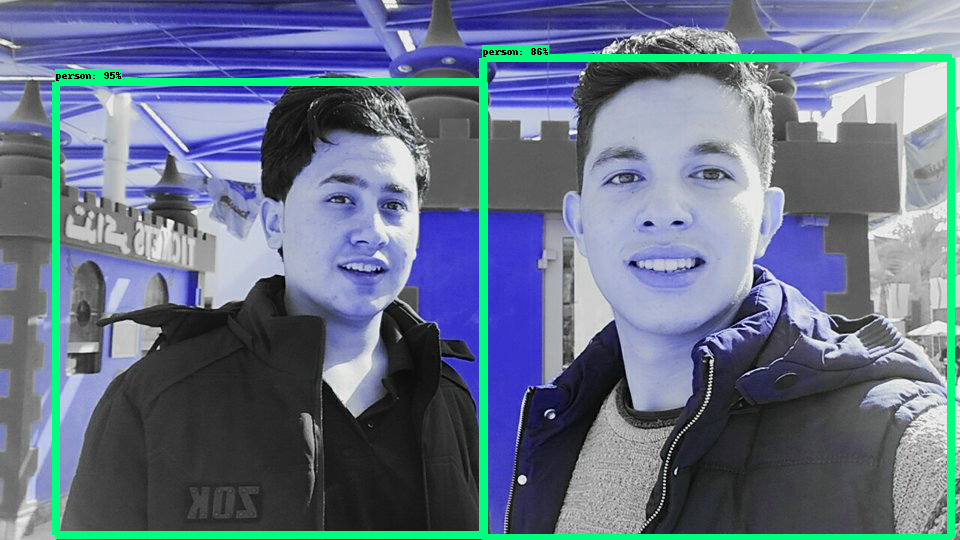

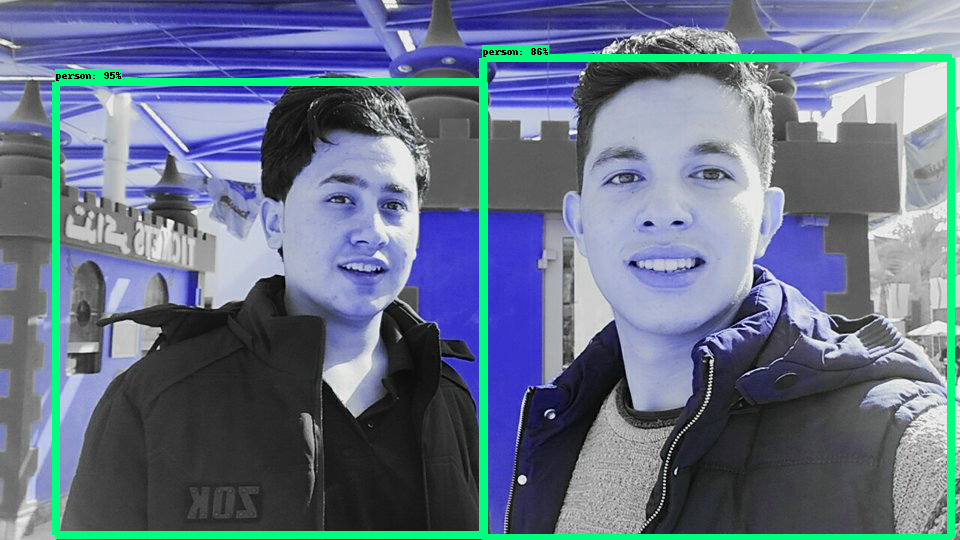

In [33]:
with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
    for image_path in TEST_IMAGE_PATHS:
      image = Image.open('/content/7.jpg')
      # the array based representation of the image will be used later in order to prepare the
      # result image with boxes and labels on it.
      image_np = load_image_into_numpy_array(image)
      # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
      image_np_expanded = np.expand_dims(image_np, axis=0)
      image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
      # Each box represents a part of the image where a particular object was detected.
      boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
      # Each score represent how level of confidence for each of the objects.
      # Score is shown on the result image, together with the class label.
      scores = detection_graph.get_tensor_by_name('detection_scores:0')
      classes = detection_graph.get_tensor_by_name('detection_classes:0')
      num_detections = detection_graph.get_tensor_by_name('num_detections:0')
      # Actual detection.
      (boxes, scores, classes, num_detections) = sess.run(
          [boxes, scores, classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})
      # Visualization of the results of a detection.
      vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          np.squeeze(boxes),
          np.squeeze(classes).astype(np.int32),
          np.squeeze(scores),
          category_index,
          use_normalized_coordinates=True,
          line_thickness=8)
      plt.figure(figsize=IMAGE_SIZE)
      plt.imshow(image_np)
      cv2_imshow(image_np)
plt.show()      

In [32]:
  from google.colab.patches import cv2_imshow